# Financial News NLP — EDA & Problem Framing

**What this notebook does:** loads three headline datasets (CNBC, Reuters, Guardian), inspects their structure, standardizes them into one combined table, and defines the NLP problem we will solve.

**Why it matters:** before modeling, we need to confirm what columns exist, how complete they are, and what the “text” field actually is.

## Imports and display settings

We import common data tools (pandas/numpy) and plotting libraries.  
We also adjust display options so headline text and columns are easier to inspect during EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 200)

## Load raw headline datasets

We load the three CSV files from `data/raw/` into separate DataFrames.  
This keeps each source isolated at first so we can compare schemas before merging.

In [2]:
DATA_DIR = "../data/raw/"

cnbc = pd.read_csv(f"{DATA_DIR}cnbc_headlines.csv")
reuters = pd.read_csv(f"{DATA_DIR}reuters_headlines.csv")
guardian = pd.read_csv(f"{DATA_DIR}guardian_headlines.csv")

{
    "cnbc": cnbc.shape,
    "reuters": reuters.shape,
    "guardian": guardian.shape
}

{'cnbc': (3080, 3), 'reuters': (32770, 3), 'guardian': (17800, 2)}

## Inspect schemas (column names)

We print each dataset’s column names to confirm:
- what fields are available (e.g., Time, Headline, Description)
- whether column names match across sources
- what needs to be standardized before combining

In [3]:
print("CNBC columns:", cnbc.columns.tolist())
print("Reuters columns:", reuters.columns.tolist())
print("Guardian columns:", guardian.columns.tolist())

CNBC columns: ['Headlines', 'Time', 'Description']
Reuters columns: ['Headlines', 'Time', 'Description']
Guardian columns: ['Time', 'Headlines']


## Preview sample rows

We display a few rows from each dataset to verify:
- the headline text is present and readable
- time fields look reasonable
- any additional fields (e.g., description) exist and may be useful later

In [4]:
cnbc.head(3)

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covid-19 vaccine gold rush,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying four companies that are supporting vaccine developers."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightning round bell, which means he's giving his answers to callers' stock questions at rapid speed."
2,NaN,NaN,NaN


In [5]:
reuters.head(3)

,Headlines,Time,Description
0,TikTok considers London and other locations for headquarters,Jul 18 2020,"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itsel..."
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as the social media giant faces an ad boycott over its handling of hate speech and controversial conte...
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,"Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspended and may still be in Belarus or Russia, a German magazine reported on Saturday."


In [6]:
guardian.head(3)

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of working life upended by Covid-19
2,18-Jul-20,Five key areas Sunak must tackle to serve up economic recovery


## Dataset Overview

Each dataset consists of financial news headlines published by a major media outlet.

- **CNBC**: business-focused headlines with emphasis on markets, earnings, and macro events.
- **Reuters**: concise, fact-driven headlines with global coverage.
- **The Guardian**: broader economic and political framing with international perspective.

Each row represents a single news headline and associated metadata such as
publication date and source.

**Key observation:** the shared “text” field across all three sources is `Headlines` (after lowercasing: `headlines`).

## Standardize column names + add `source`

We standardize each DataFrame by:
- lowercasing all column names for consistency
- adding a `source` column so we can compare outlets after merging

This makes the combined dataset easier to work with downstream.

In [7]:
def standardize(df, source_name):
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]
    df["source"] = source_name
    return df

cnbc = standardize(cnbc, "CNBC")
reuters = standardize(reuters, "Reuters")
guardian = standardize(guardian, "Guardian")

## Confirm the NLP text field

We re-check a sample row after standardization to confirm which column contains the headline text.  
For this project, the primary NLP input column is `headlines`.

In [8]:
cnbc.head(1)

,headlines,time,description,source
0,Jim Cramer: A better way to invest in the Covid-19 vaccine gold rush,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying four companies that are supporting vaccine developers.",CNBC


## Combine all sources into one dataset

We concatenate the three sources into a single DataFrame (`news_df`).  
This allows unified analysis while preserving the `source` label for comparisons.

In [9]:
news_df = pd.concat([cnbc, reuters, guardian], ignore_index=True)
news_df.shape

(53650, 4)

## NLP Input Definition

The primary NLP input for this project is the **news headline text**.

Headlines are short, information-dense summaries designed to capture the
most salient aspect of a financial event. Despite their brevity, they often
encode sentiment, urgency, and thematic focus.

By analyzing headlines across multiple sources, we can study:
- dominant market narratives
- sentiment shifts over time
- differences in framing between outlets

**We will treat `headlines` as the core text input for all NLP steps (cleaning, TF-IDF, embeddings, topic modeling).**

## Data quality: missing values

We check missing values to understand:
- whether any columns require cleaning or dropping
- how complete the headline text is
- whether “description” fields are consistently available (optional feature later)

In [10]:
news_df.isnull().sum().sort_values(ascending=False)

description    18080
headlines        280
time             280
source             0
dtype: int64

## Dataset balance by source

We compute headline counts per source and visualize the distribution.  
This helps us understand dataset imbalance (e.g., Reuters has many more headlines) which can affect downstream modeling and topic comparisons.

In [12]:
news_df["source"].value_counts()

source
Reuters     32770
Guardian    17800
CNBC         3080
Name: count, dtype: int64

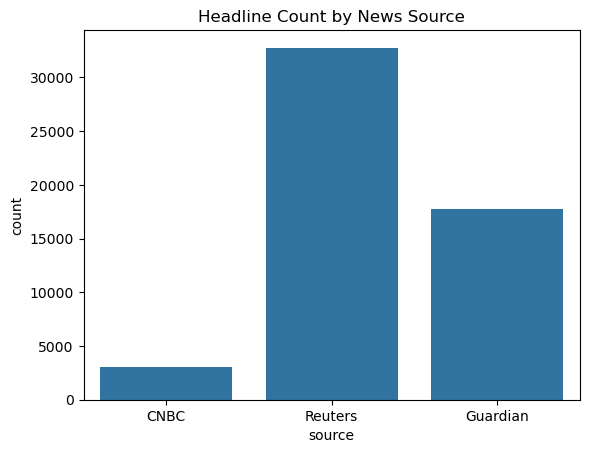

In [13]:
sns.countplot(data=news_df, x="source")
plt.title("Headline Count by News Source")
plt.show()

## Problem Framing

This project focuses on **unsupervised and descriptive NLP**, rather than
price prediction.

Primary questions include:
- What major themes dominate financial news coverage?
- How do narratives differ across news sources?
- How does sentiment and topic focus change over time?

The objective is to extract interpretable market narratives from text,
not to make direct trading claims.

## Summary & Next Steps

In this notebook, we:
- loaded and inspected three financial news datasets
- standardized schema and combined sources
- identified headlines as the core NLP input
- defined a clear narrative-focused NLP objective

Next steps:
- clean and normalize headline text
- build baseline NLP representations (TF-IDF)
- explore sentiment and topic modeling

**Deliverable after Notebook 01:** one clean combined dataset (`news_df`) and a clear NLP plan for the next notebook (text cleaning + baseline representations).